# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
import torchvision.models as models
import numpy as np
from glob import glob

# load filenames for human and dog images
#human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dog_images/*/*/*"))

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dog_images/train/*/"))]
dog_breeds = len(dog_names)

# print number of images in each dataset
print('There are %d total dog categories.' % len(dog_names))
#print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 133 total dog categories.
There are 8351 total dog images.


In [3]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transform={
    'test':    transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.ToTensor(),
               normalize
                ]),

    'train':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ]),

    'valid':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ])
        }

data_dir='dog_images/'

data_transfer={x:datasets.ImageFolder(data_dir+x, transform=transform[x])
             for x in ['train','test','valid']}

#train_data=datasets.ImageFolder(data_dir+'/train', transform=transform['train'])
#valid_data=datasets.ImageFolder(data_dir+'/valid', transform=valid_transform['valid'])
#test_data=datasets.ImageFolder(data_dir+'/test', transform=test_transform['test'])

batch_size=32
num_workers=0

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#    shuffle=True,num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)

loaders_transfer={
    x:torch.utils.data.DataLoader(data_transfer[x], batch_size=batch_size,
    shuffle=True,num_workers=num_workers)
    for x in ['train','test','valid'] 
    }

In [4]:
print(len(loaders_transfer['train'].dataset))
print(len(loaders_transfer['test'].dataset))
print(len(loaders_transfer['valid'].dataset))

6680
836
835


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


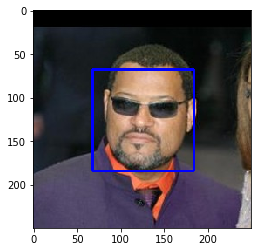

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(r"C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml")

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [8]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Vectorize the face dectector function
vfunc = np.vectorize(face_detector)


# Detect faces in both sets
human_faces = vfunc(human_files_short)
dog_faces = vfunc(dog_files_short)

human_face_detection_percentage=sum(human_faces)/len(human_faces)*100
dog_face_detection_percentage=sum(dog_faces)/len(dog_faces)*100

# Calculate and print percentage of faces in each set
print('{:.2f}% percentage of the first 100 images in human_files have a detected human face.'.format(human_face_detection_percentage))
print('{:.2f}% percentage of the first 100 images in dog_files have a detected human face.'.format(dog_face_detection_percentage))

99.00% percentage of the first 100 images in human_files have a detected human face.
18.00% percentage of the first 100 images in dog_files have a detected human face.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__  There are different ways to detect face using Python OpenCV. It already has two pre-trained face detection classifiers, which can readily be used in a program. The two classifiers are:

* Haar Classifier and
* Local Binary Pattern(LBP) classifier.

The following blog discuss about this classifer in details https://www.datacamp.com/community/tutorials/face-detection-python-opencv

The more accurate OpenCV face detector is deep learning based, and in particular, utilizes the Single Shot Detector (SSD) framework with ResNet as the base network. https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [VGG16](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained VGG16 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

#use_cuda=False

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

### Making Predictions with VGG16

Getting the 4D tensor ready for VGG16, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to VGG16, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

In [12]:
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

def VGG16_predict(img_path):
    '''
    Use pre-trained densenet161 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to densenet161 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # loads RGB image as PIL.Image.Image type
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = VGG16(img_tensor)
    value, index = torch.max(fc_out, 1)
    
    
    
    return np.asscalar(index.cpu().data[0].numpy()) # predicted class index

print(VGG16_predict(dog_files[1200]))


258


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG16 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return ((prediction <= 268) & (prediction >= 151))

print(dog_detector(human_files[0]))
print(dog_detector(dog_files[0]))

False
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human_files_short)
dog_dogs = dog_vfunc(dog_files_short)

human_face_detection_percentage=sum(human_dogs)/len(human_dogs)*100
dog_face_detection_percentage=sum(dog_dogs)/len(dog_dogs)*100

# Calculate and print percentage of faces in each set
print('{:.2f}% of the images in human_files_short have a detected dog.'.format(human_face_detection_percentage))
print('{:.2f}% of the images in dog_files_short have a detected dog.'.format(dog_face_detection_percentage))

1.00% of the images in human_files_short have a detected dog.
94.00% of the images in dog_files_short have a detected dog.


In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer2(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = model_transfer2(img_tensor)
    value, index = torch.max(fc_out, 1)
    
    return class_names[np.asscalar(index.cpu().data[0].numpy())]
    
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer_topk(img_path,model,k):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = model(img_tensor)
    probability = F.softmax(fc_out.data,dim=1)
    value, index = torch.topk(probability, k)
    
    
    
    return index.cpu().data[0].numpy(), value.cpu().data[0].numpy() 

In [44]:
import torch.nn.functional as F

breeds, values= predict_breed_transfer_topk('images/Labrador_retriever_06449.jpg', model_transfer2, 5)

In [45]:
print(breeds)
print(values)

['Labrador retriever', 'Great dane', 'Plott', 'Black and tan coonhound', 'Flat-coated retriever']
[9.9428326e-01 1.3659516e-03 1.1888425e-03 1.1396845e-03 6.4659916e-04]


['Labrador retriever', 'Great dane', 'Plott', 'Black and tan coonhound', 'Flat-coated retriever']


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    breed= predict_breed_transfer2(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # since the dog detector worked better, and we don't have 
    # access to softmax probabilities from dog and face detectors
    # we'll first check for dog detection, and only if there are no dogs
    # detected we'll check for humans
    if dog_detector(img_path):
        print('Hello Dog!')
        plt.figure()
        plt.imshow(img)
        print('You look like a {}.'.format(breed))
        
    elif face_detector(img_path):
        print('Hello human!')
        plt.figure()
        plt.imshow(img)
        print('If you were a dog, you\'d be a {}.'.format(breed))
    else:
        print('Could not detect dogs or humans in image.')
        plt.figure()
        plt.imshow(img)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Hello Dog!
You look like a Brittany.


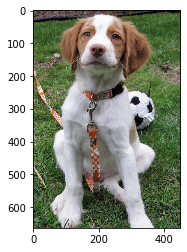

In [32]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
run_app('images/Brittany.jpg')

Hello Dog!
You look like a Labrador retriever.


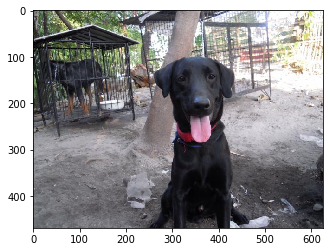

In [33]:
run_app('images/Labrador_retriever_06449.jpg')

Could not detect dogs or humans in image.


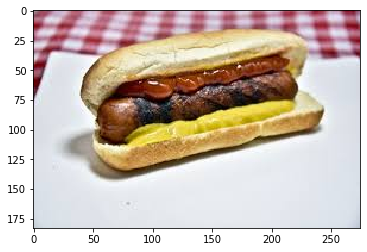

In [34]:
run_app('images/hot_dog2.jpg')

Hello human!
If you were a dog, you'd be a Wirehaired pointing griffon.


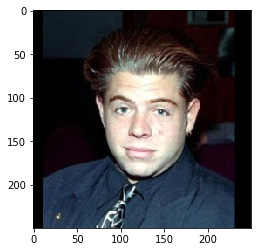

In [35]:
run_app('lfw/Adam_Rich/Adam_Rich_0001.jpg')

Hello human!
If you were a dog, you'd be a Affenpinscher.


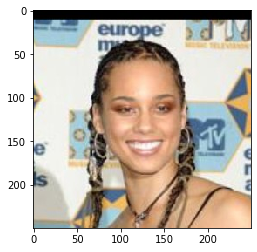

In [36]:
run_app('lfw/Alicia_Keys/Alicia_Keys_0001.jpg')

Could not detect dogs or humans in image.


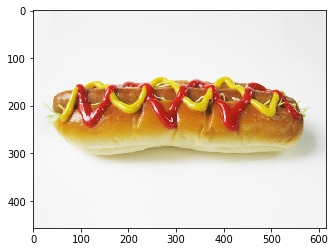

In [37]:
run_app('images/hot_dog1.jpg')

Hello human!
If you were a dog, you'd be a Alaskan malamute.


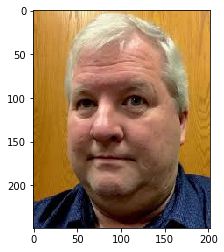

In [38]:
run_app(r'C:\Users\Ahmed\Desktop\brent.jpg')

In [39]:
import os
total=0
count=0
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    #for subname in subdirList:
    for fname in fileList:
        #print('\t%s/%s' % (dirName, fname))
        fileName=dirName+'/'+fname
        total=total+1
        classes = predict_breed_transfer2(fileName)
        #print(classes)
        #classes = classes.cpu().data.numpy()[1][0]#convert class integer to flower name
        #title = classes[0] #highest probability class
        if classes!=subdir[4:].replace("_", " "):
            print('miss classified file %s:'%fileName)
            #print(fileName)
            print('predicted class: '+classes)
            count=count+1
print('total misclassification: %d'%count)
print('total test file: %d'%total)


miss classified file dog_images/test/001.Affenpinscher/Affenpinscher_00058.jpg:
predicted class: Lowchen
miss classified file dog_images/test/004.Akita/Akita_00244.jpg:
predicted class: Norwegian lundehund
miss classified file dog_images/test/004.Akita/Akita_00262.jpg:
predicted class: Australian cattle dog
miss classified file dog_images/test/006.American_eskimo_dog/American_eskimo_dog_00471.jpg:
predicted class: Icelandic sheepdog
miss classified file dog_images/test/007.American_foxhound/American_foxhound_00522.jpg:
predicted class: Basset hound
miss classified file dog_images/test/007.American_foxhound/American_foxhound_00524.jpg:
predicted class: Beagle
miss classified file dog_images/test/012.Australian_shepherd/Australian_shepherd_00836.jpg:
predicted class: English setter
miss classified file dog_images/test/012.Australian_shepherd/Australian_shepherd_00868.jpg:
predicted class: Icelandic sheepdog
miss classified file dog_images/test/016.Beagle/Beagle_01150.jpg:
predicted class

miss classified file dog_images/test/078.Great_dane/Great_dane_05326.jpg:
predicted class: Mastiff
miss classified file dog_images/test/078.Great_dane/Great_dane_05329.jpg:
predicted class: Cane corso
miss classified file dog_images/test/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05469.jpg:
predicted class: Entlebucher mountain dog
miss classified file dog_images/test/081.Greyhound/Greyhound_05542.jpg:
predicted class: Manchester terrier
miss classified file dog_images/test/082.Havanese/Havanese_05566.jpg:
predicted class: Maltese
miss classified file dog_images/test/082.Havanese/Havanese_05614.jpg:
predicted class: Lowchen
miss classified file dog_images/test/082.Havanese/Havanese_05625.jpg:
predicted class: Lowchen
miss classified file dog_images/test/084.Icelandic_sheepdog/Icelandic_sheepdog_05746.jpg:
predicted class: Cardigan welsh corgi
miss classified file dog_images/test/088.Irish_water_spaniel/Irish_water_spaniel_05975.jpg:
predicted class: Poodle
miss classifie

In [40]:
import os
 
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    print(subdir[4:].replace("_", " "), len(fileList))

 0
Affenpinscher 8
Afghan hound 8
Airedale terrier 6
Akita 8
Alaskan malamute 10
American eskimo dog 8
American foxhound 7
American staffordshire terrier 8
American water spaniel 4
Anatolian shepherd dog 6
Australian cattle dog 9
Australian shepherd 9
Australian terrier 6
Basenji 9
Basset hound 10
Beagle 8
Bearded collie 8
Beauceron 7
Bedlington terrier 6
Belgian malinois 8
Belgian sheepdog 8
Belgian tervuren 6
Bernese mountain dog 8
Bichon frise 8
Black and tan coonhound 4
Black russian terrier 5
Bloodhound 8
Bluetick coonhound 4
Border collie 10
Border terrier 7
Borzoi 7
Boston terrier 8
Bouvier des flandres 5
Boxer 8
Boykin spaniel 6
Briard 8
Brittany 6
Brussels griffon 7
Bull terrier 9
Bulldog 7
Bullmastiff 9
Cairn terrier 8
Canaan dog 6
Cane corso 8
Cardigan welsh corgi 7
Cavalier king charles spaniel 9
Chesapeake bay retriever 7
Chihuahua 7
Chinese crested 6
Chinese shar-pei 6
Chow chow 8
Clumber spaniel 6
Cocker spaniel 6
Collie 7
Curly-coated retriever 7
Dachshund 9
Dalmatian 9

In [54]:
import os
total=0
#count=0
top1=0
top3=0
top5=0
list1=[]
list3=[]
list5=[]
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    #for subname in subdirList:
    for fname in fileList:
        #print('\t%s/%s' % (dirName, fname))
        fileName=dirName+'/'+fname
        total=total+1
        classes,_ = predict_breed_transfer_topk(fileName, model_transfer2, 5)
        
        #classes = classes.cpu().data.numpy()[1][0]#convert class integer to flower name
        #title = classes[0] #highest probability class
        if subdir[4:].replace("_", " ") not in classes[0:1]:
            print('*File name:Top1 error '+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top1=top1+1
            list1.append(fileName)
        if subdir[4:].replace("_", " ") not in classes[0:3]:
            print('***File name: top3 error '+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top3=top3+1
            list3.append(fileName)
        if subdir[4:].replace("_", " ") not in classes[0:5]:
            print('*****File name: for top5 error'+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top5=top5+1
            list5.append(fileName)
        
print('total misclassification top1: %d'%top1)
print('total misclassification top3: %d'%top3)
print('total misclassification top5: %d'%top5)
print('total test file: %d'%total)
print('Top1 error: %f', top1/total*100)
print('Top3 error: %f', top3/total*100)
print('Top5 error: %f', top5/total*100)

*File name:Top1 error dog_images/test/001.Affenpinscher/Affenpinscher_00058.jpg
['Lowchen', 'Affenpinscher', 'Havanese', 'Lhasa apso', 'Wirehaired pointing griffon']
*File name:Top1 error dog_images/test/004.Akita/Akita_00244.jpg
['Norwegian lundehund', 'Alaskan malamute', 'Akita', 'German shepherd dog', 'Cardigan welsh corgi']
*File name:Top1 error dog_images/test/004.Akita/Akita_00262.jpg
['Australian cattle dog', 'Akita', 'Canaan dog', 'Greyhound', 'Basenji']
*File name:Top1 error dog_images/test/006.American_eskimo_dog/American_eskimo_dog_00471.jpg
['Icelandic sheepdog', 'Pomeranian', 'American eskimo dog', 'Finnish spitz', 'Norwegian buhund']
*File name:Top1 error dog_images/test/007.American_foxhound/American_foxhound_00522.jpg
['Basset hound', 'American foxhound', 'Beagle', 'Dachshund', 'Irish red and white setter']
*File name:Top1 error dog_images/test/007.American_foxhound/American_foxhound_00524.jpg
['Beagle', 'American foxhound', 'Basset hound', 'Brittany', 'Pointer']
*File 

*File name:Top1 error dog_images/test/061.English_cocker_spaniel/English_cocker_spaniel_04359.jpg
['Gordon setter', 'English cocker spaniel', 'Otterhound', 'Field spaniel', 'Clumber spaniel']
*File name:Top1 error dog_images/test/063.English_springer_spaniel/English_springer_spaniel_04486.jpg
['Belgian malinois', 'Canaan dog', 'Greyhound', 'Pointer', 'Anatolian shepherd dog']
***File name: top3 error dog_images/test/063.English_springer_spaniel/English_springer_spaniel_04486.jpg
['Belgian malinois', 'Canaan dog', 'Greyhound', 'Pointer', 'Anatolian shepherd dog']
*****File name: for top5 errordog_images/test/063.English_springer_spaniel/English_springer_spaniel_04486.jpg
['Belgian malinois', 'Canaan dog', 'Greyhound', 'Pointer', 'Anatolian shepherd dog']
*File name:Top1 error dog_images/test/064.English_toy_spaniel/English_toy_spaniel_04513.jpg
['Cavalier king charles spaniel', 'English toy spaniel', 'Papillon', 'Japanese chin', 'Irish red and white setter']
*File name:Top1 error dog_im

*File name:Top1 error dog_images/test/088.Irish_water_spaniel/Irish_water_spaniel_05975.jpg
['Poodle', 'Irish water spaniel', 'Portuguese water dog', 'American water spaniel', 'Afghan hound']
*File name:Top1 error dog_images/test/088.Irish_water_spaniel/Irish_water_spaniel_06011.jpg
['Curly-coated retriever', 'Irish water spaniel', 'American water spaniel', 'Poodle', 'Portuguese water dog']
*File name:Top1 error dog_images/test/089.Irish_wolfhound/Irish_wolfhound_06052.jpg
['Bearded collie', 'Otterhound', 'Wirehaired pointing griffon', 'Glen of imaal terrier', 'Irish wolfhound']
***File name: top3 error dog_images/test/089.Irish_wolfhound/Irish_wolfhound_06052.jpg
['Bearded collie', 'Otterhound', 'Wirehaired pointing griffon', 'Glen of imaal terrier', 'Irish wolfhound']
*File name:Top1 error dog_images/test/090.Italian_greyhound/Italian_greyhound_06114.jpg
['German pinscher', 'Manchester terrier', 'Pharaoh hound', 'Doberman pinscher', 'Dachshund']
***File name: top3 error dog_images/te

In [55]:
list5

['dog_images/test/016.Beagle/Beagle_01150.jpg',
 'dog_images/test/061.English_cocker_spaniel/English_cocker_spaniel_04322.jpg',
 'dog_images/test/063.English_springer_spaniel/English_springer_spaniel_04486.jpg',
 'dog_images/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05060.jpg',
 'dog_images/test/074.Giant_schnauzer/Giant_schnauzer_05120.jpg',
 'dog_images/test/078.Great_dane/Great_dane_05329.jpg',
 'dog_images/test/090.Italian_greyhound/Italian_greyhound_06114.jpg',
 'dog_images/test/108.Norwegian_buhund/Norwegian_buhund_07120.jpg',
 'dog_images/test/109.Norwegian_elkhound/Norwegian_elkhound_07170.jpg']

In [56]:
list3

['dog_images/test/016.Beagle/Beagle_01150.jpg',
 'dog_images/test/061.English_cocker_spaniel/English_cocker_spaniel_04322.jpg',
 'dog_images/test/061.English_cocker_spaniel/English_cocker_spaniel_04323.jpg',
 'dog_images/test/063.English_springer_spaniel/English_springer_spaniel_04486.jpg',
 'dog_images/test/067.Finnish_spitz/Finnish_spitz_04648.jpg',
 'dog_images/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05027.jpg',
 'dog_images/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05060.jpg',
 'dog_images/test/074.Giant_schnauzer/Giant_schnauzer_05120.jpg',
 'dog_images/test/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05149.jpg',
 'dog_images/test/078.Great_dane/Great_dane_05326.jpg',
 'dog_images/test/078.Great_dane/Great_dane_05329.jpg',
 'dog_images/test/089.Irish_wolfhound/Irish_wolfhound_06052.jpg',
 'dog_images/test/090.Italian_greyhound/Italian_greyhound_06114.jpg',
 'dog_images/test/108.Norwegian_buhund/Norwegian_buhund_07120.jpg',
 'dog_images/t

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


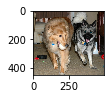

In [70]:
i=0
for f in list5:
    plt.subplot(3,3,i+1)
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.figure()
    plt.imshow(img)
plt.show()
    


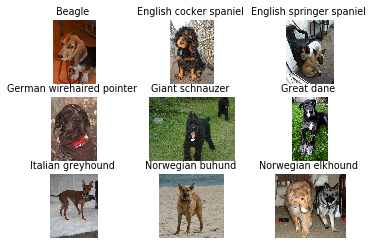

In [88]:
import matplotlib
i=1

SMALL_SIZE = 8
matplotlib.rc('font', size=SMALL_SIZE)
f, axarr = plt.subplots(3, 3)

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()

axarr[0,0].imshow(img)
axarr[0,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[0,1].imshow(img)
axarr[0,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[0,2].imshow(img)
axarr[0,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,2].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,0].imshow(img)
axarr[1,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,1].imshow(img)
axarr[1,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,2].imshow(img)
axarr[1,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,2].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,0].imshow(img)
axarr[2,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,1].imshow(img)
axarr[2,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,2].imshow(img)
axarr[2,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,2].set_title(breed)
plt.show()

In [90]:
### TODO: Define your architecture.
import torchvision.models as models
import torch.nn as nn

### TODO: Load the model weights with the best validation loss.
model_transfer2 = models.vgg16(pretrained=True)

for param in model_transfer2.parameters():
    param.requires_grad=False

#from collections import OrderedDict

model_transfer2.classifier[6]=nn.Linear(model_transfer2.classifier[6].in_features,dog_breeds)

#model_transfer.=classifier

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer2.load_state_dict(torch.load('model_transfer.pth'))
if use_cuda:
    model_transfer2 = model_transfer2.cuda()

In [91]:
import os
total=0
#count=0
top1=0
top3=0
top5=0
list1=[]
list3=[]
list5=[]
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    #for subname in subdirList:
    for fname in fileList:
        #print('\t%s/%s' % (dirName, fname))
        fileName=dirName+'/'+fname
        total=total+1
        classes,_ = predict_breed_transfer_topk(fileName, model_transfer2, 5)
        
        #classes = classes.cpu().data.numpy()[1][0]#convert class integer to flower name
        #title = classes[0] #highest probability class
        if subdir[4:].replace("_", " ") not in classes[0:1]:
            print('*File name:Top1 error '+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top1=top1+1
            list1.append(fileName)
        if subdir[4:].replace("_", " ") not in classes[0:3]:
            print('***File name: top3 error '+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top3=top3+1
            list3.append(fileName)
        if subdir[4:].replace("_", " ") not in classes[0:5]:
            print('*****File name: for top5 error'+fileName)
            print(classes)
            #print('miss classified file %s:'%fileName)
            #print(fileName)
            #print(classes)
            top5=top5+1
            list5.append(fileName)
        
print('total misclassification top1: %d'%top1)
print('total misclassification top3: %d'%top3)
print('total misclassification top5: %d'%top5)
print('total test file: %d'%total)
print('Top1 error: %f', top1/total*100)
print('Top3 error: %f', top3/total*100)
print('Top5 error: %f', top5/total*100)

*File name:Top1 error dog_images/test/002.Afghan_hound/Afghan_hound_00141.jpg
['Cocker spaniel', 'Pekingese', 'Afghan hound', 'English toy spaniel', 'Chinese crested']
*File name:Top1 error dog_images/test/002.Afghan_hound/Afghan_hound_00146.jpg
['English setter', 'Afghan hound', 'English cocker spaniel', 'Chinese crested', 'Dachshund']
*File name:Top1 error dog_images/test/004.Akita/Akita_00244.jpg
['Alaskan malamute', 'Norwegian lundehund', 'Akita', 'Cardigan welsh corgi', 'Australian cattle dog']
*File name:Top1 error dog_images/test/004.Akita/Akita_00276.jpg
['Finnish spitz', 'Akita', 'Canaan dog', 'Icelandic sheepdog', 'Cardigan welsh corgi']
*File name:Top1 error dog_images/test/006.American_eskimo_dog/American_eskimo_dog_00471.jpg
['Pomeranian', 'Icelandic sheepdog', 'Finnish spitz', 'Chinese crested', 'Norwegian buhund']
***File name: top3 error dog_images/test/006.American_eskimo_dog/American_eskimo_dog_00471.jpg
['Pomeranian', 'Icelandic sheepdog', 'Finnish spitz', 'Chinese c

*File name:Top1 error dog_images/test/050.Chinese_shar-pei/Chinese_shar-pei_03580.jpg
['Dogue de bordeaux', 'Chinese shar-pei', 'Cane corso', 'American staffordshire terrier', 'Bullmastiff']
*File name:Top1 error dog_images/test/052.Clumber_spaniel/Clumber_spaniel_03680.jpg
['Welsh springer spaniel', 'English cocker spaniel', 'Brittany', 'Clumber spaniel', 'English springer spaniel']
***File name: top3 error dog_images/test/052.Clumber_spaniel/Clumber_spaniel_03680.jpg
['Welsh springer spaniel', 'English cocker spaniel', 'Brittany', 'Clumber spaniel', 'English springer spaniel']
*File name:Top1 error dog_images/test/053.Cocker_spaniel/Cocker_spaniel_03743.jpg
['Boykin spaniel', 'English cocker spaniel', 'Cocker spaniel', 'English springer spaniel', 'English toy spaniel']
*File name:Top1 error dog_images/test/053.Cocker_spaniel/Cocker_spaniel_03748.jpg
['Dachshund', 'English cocker spaniel', 'Cocker spaniel', 'Golden retriever', 'English setter']
*File name:Top1 error dog_images/test/05

*File name:Top1 error dog_images/test/078.Great_dane/Great_dane_05329.jpg
['Boston terrier', 'Cane corso', 'Greyhound', 'Entlebucher mountain dog', 'American staffordshire terrier']
***File name: top3 error dog_images/test/078.Great_dane/Great_dane_05329.jpg
['Boston terrier', 'Cane corso', 'Greyhound', 'Entlebucher mountain dog', 'American staffordshire terrier']
*****File name: for top5 errordog_images/test/078.Great_dane/Great_dane_05329.jpg
['Boston terrier', 'Cane corso', 'Greyhound', 'Entlebucher mountain dog', 'American staffordshire terrier']
*File name:Top1 error dog_images/test/079.Great_pyrenees/Great_pyrenees_05365.jpg
['Kuvasz', 'Great pyrenees', 'Golden retriever', 'Chow chow', 'Newfoundland']
*File name:Top1 error dog_images/test/079.Great_pyrenees/Great_pyrenees_05367.jpg
['Kuvasz', 'Great pyrenees', 'Anatolian shepherd dog', 'Labrador retriever', 'Golden retriever']
*File name:Top1 error dog_images/test/081.Greyhound/Greyhound_05542.jpg
['Manchester terrier', 'German p

*File name:Top1 error dog_images/test/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07622.jpg
['Cardigan welsh corgi', 'Basenji', 'Icelandic sheepdog', 'Norwegian lundehund', 'Pembroke welsh corgi']
***File name: top3 error dog_images/test/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07622.jpg
['Cardigan welsh corgi', 'Basenji', 'Icelandic sheepdog', 'Norwegian lundehund', 'Pembroke welsh corgi']
*File name:Top1 error dog_images/test/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07658.jpg
['Cardigan welsh corgi', 'Pembroke welsh corgi', 'Icelandic sheepdog', 'Norwegian lundehund', 'Canaan dog']
*File name:Top1 error dog_images/test/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07673.jpg
['Basenji', 'Cardigan welsh corgi', 'Pembroke welsh corgi', 'Canaan dog', 'Norwegian lundehund']
*File name:Top1 error dog_images/test/122.Pointer/Pointer_07812.jpg
['German shorthaired pointer', 'Pointer', 'Great dane', 'German wirehaired pointer', 'Bluetick coonhound']
*File name:Top1 error dog_image

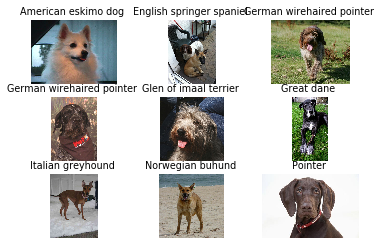

In [94]:
import matplotlib
i=1

SMALL_SIZE = 8
matplotlib.rc('font', size=SMALL_SIZE)
f, axarr = plt.subplots(3, 3)

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()

axarr[0,0].imshow(img)
axarr[0,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[0,1].imshow(img)
axarr[0,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[0,2].imshow(img)
axarr[0,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[0,2].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,0].imshow(img)
axarr[1,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,1].imshow(img)
axarr[1,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[1,2].imshow(img)
axarr[1,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[1,2].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,0].imshow(img)
axarr[2,0].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,0].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,1].imshow(img)
axarr[2,1].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,1].set_title(breed)
i+=1

img = cv2.imread(list5[i-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure()
axarr[2,2].imshow(img)
axarr[2,2].axis('off')
breed=list5[i-1].split('/')[-1].split('.')[0][:-5].replace("_", " ")
axarr[2,2].set_title(breed)
plt.show()

In [ ]:
breedname=[dirName.split('/')[-1][4:].replace("_", " ") for dirName, subdirList, fileList in os.walk(rootDir)]

In [ ]:
example_test=[len(fileList)for dirName, subdirList, fileList in os.walk(rootDir)]

In [ ]:
breedname.pop(0)

In [ ]:
example_test.pop(0)

In [ ]:
import pandas as pd
df_test = pd.DataFrame(list(zip(breedname, example_test)), columns =['Breed', 'test_count']) 

In [ ]:
df_test.head()

In [ ]:
ax = df_test.plot.bar(x='Breed', y='test_count', rot=90, figsize=(15,7),title="Test Images Distribution")

In [ ]:
rootDir = 'dog_images/train/'
breedname=[dirName.split('/')[-1][4:].replace("_", " ") for dirName, subdirList, fileList in os.walk(rootDir)]
example_train=[len(fileList)for dirName, subdirList, fileList in os.walk(rootDir)]
breedname.pop(0)
example_train.pop(0)
import pandas as pd
df_train = pd.DataFrame(list(zip(breedname, example_train)), columns =['Breed', 'train_count'])
ax = df_train.plot.bar(x='Breed', y='train_count', rot=90, figsize=(15,7),title="Train Images Distribution")

In [ ]:
rootDir = 'dog_images/valid/'
breedname=[dirName.split('/')[-1][4:].replace("_", " ") for dirName, subdirList, fileList in os.walk(rootDir)]
example_valid=[len(fileList)for dirName, subdirList, fileList in os.walk(rootDir)]
breedname.pop(0)
example_valid.pop(0)
import pandas as pd
df_valid = pd.DataFrame(list(zip(breedname, example_valid)), columns =['Breed', 'valid_count'])
ax = df_valid.plot.bar(x='Breed', y='valid_count', rot=90, figsize=(15,7),title="Valid Images Distribution")

In [ ]:
df_test.describe()

In [ ]:
df_train.describe()

In [ ]:
df_valid.describe()

In [ ]:
df_all=pd.DataFrame(zip(breedname,example_train,example_valid,example_test),columns=['Breed','Train','Valid','Test'])

In [ ]:
df

In [ ]:
df_all.describe()